## MODELING

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.pylab as pylab
import seaborn as sns

from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score, cross_validate
from sklearn.model_selection import KFold 
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.inspection import permutation_importance

import xgboost as xgb
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier

from sklearn.metrics import roc_curve, auc, roc_auc_score, accuracy_score, recall_score, precision_score, f1_score, average_precision_score 
from sklearn.metrics import confusion_matrix, plot_confusion_matrix, classification_report
from sklearn.metrics import plot_precision_recall_curve, precision_recall_curve


sns.set(color_codes = True)

pd.set_option('display.max_rows', 50)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

%matplotlib inline

In [3]:
# df_household_demo= pd.read_csv('DATA_CLEAN/households_beforeCamp18_02.csv')

# df_household_demo= pd.read_csv('DATA_CLEAN2/households_beforeCamp18_02_with_zipcode.csv')

df_household_demo= pd.read_csv('DATA_CLEAN/households_withDemographic_beforeCamp18.csv')

In [4]:
df_household_demo[df_household_demo.redeemed_campA_18==1].zip_code

0          0
3      62946
6      62959
9      38401
14     40342
       ...  
788    40203
790    37211
794    40213
796    42301
797    38401
Name: zip_code, Length: 166, dtype: int64

In [5]:
df_household_demo[df_household_demo.zip_code==0].shape

(28, 66)

In [7]:
# get all numerical columns
numerical_dtypes = ['int16','int32', 'int64','float16','float32','float64']
num_cols = []
for i in df_household_demo.columns:
    if df_household_demo[i].dtype in numerical_dtypes:
        num_cols.append(i)
        
print(len(num_cols))
print(num_cols)

cat_cols = df_household_demo.columns.difference(num_cols)
print(len(cat_cols))
print(cat_cols)


58
['household_key', 'received_campaign', 'redeemed_coupons', 'TypeA', 'TypeB', 'TypeC', 'total_campaigns_received', 'total_campaigns_engaged', 'total_coupons_received', 'total_coupons_redeemed', 'camp_conversion_rate', 'coupon_conversion_rate', 'recency', 'frequency', 'monetary', 'rfm_group', 'rfm_score', 'GROCERY_spend', 'DELI_spend', 'PRODUCE_spend', 'KIOSK-GAS_spend', 'DRUG GM_spend', 'NUTRITION_spend', 'SALAD BAR_spend', 'MEAT_spend', 'campA_26_converted', 'campA_30_converted', 'campA_8_converted', 'campA_13_converted', 'campA_18_converted', 'campB_28_converted', 'campB_29_converted', 'campB_1_converted', 'campB_2_converted', 'campB_4_converted', 'campB_5_converted', 'campB_7_converted', 'campB_9_converted', 'campB_10_converted', 'campB_12_converted', 'campB_11_converted', 'campB_16_converted', 'campB_17_converted', 'campB_19_converted', 'campB_22_converted', 'campB_21_converted', 'campB_23_converted', 'campB_25_converted', 'campB_24_converted', 'campC_27_converted', 'campC_3_conv

In [262]:
df_household_demo.segment.unique()

array(['Loyal', 'Need attention', 'Champions', 'Required activation'],
      dtype=object)

In [263]:
# ENCODE CATEGORICAL ORDINAL COLS

def factorize_ordinal_cols(data,cols,cat_list):
    for i in cols: 
        new_col = i + '_rating'
        cat = pd.Categorical(data[i], 
                         categories=cat_list, 
                         ordered=True)
        labels, unique = pd.factorize(cat, sort=True)
        data[new_col] = labels
        

cat1_cols = ['homeowner_desc']
cat2_cols = ['income_desc']
cat3_cols = ['age_desc']
cat4_cols = ['marital_status_code']
cat5_cols = ['segment']

cat1_list = ['Unknown','Probable Renter','Probable Owner','Renter','Homeowner']       
cat2_list = ['Under 15K','15-24K','25-34K','35-49K','50-74K','75-99K','100-124K','125-149K','150-174K','175-199K','200-249K','250K+']       
cat3_list = ['19-24','25-34','35-44', '45-54','55-64','65+']
cat4_list = ['U','B','A']
cat5_list = ['Required activation','Need attention','Loyal','Champions']
    
factorize_ordinal_cols(df_household_demo,cat1_cols,cat1_list)
factorize_ordinal_cols(df_household_demo,cat2_cols,cat2_list)
factorize_ordinal_cols(df_household_demo,cat3_cols,cat3_list)
factorize_ordinal_cols(df_household_demo,cat4_cols,cat4_list)
factorize_ordinal_cols(df_household_demo,cat5_cols,cat5_list)

# print(labels, unique)
df_household_demo.head()

,household_key,received_campaign,redeemed_coupons,TypeA,TypeB,TypeC,total_campaigns_received,total_campaigns_engaged,total_coupons_received,total_coupons_redeemed,camp_conversion_rate,coupon_conversion_rate,recency,frequency,monetary,rfm_group,rfm_score,segment,GROCERY_spend,DELI_spend,PRODUCE_spend,KIOSK-GAS_spend,DRUG GM_spend,NUTRITION_spend,SALAD BAR_spend,MEAT_spend,campA_26_converted,campA_30_converted,campA_8_converted,campA_13_converted,campA_18_converted,campB_28_converted,campB_29_converted,campB_1_converted,campB_2_converted,campB_4_converted,campB_5_converted,campB_7_converted,campB_9_converted,campB_10_converted,campB_12_converted,campB_11_converted,campB_16_converted,campB_17_converted,campB_19_converted,campB_22_converted,campB_21_converted,campB_23_converted,campB_25_converted,campB_24_converted,campC_27_converted,campC_3_converted,campC_6_converted,campC_14_converted,campC_15_converted,campC_20_converted,received_campA_18,redeemed_campA_18,zip_code,age_desc,marital_status_code,income_desc,homeowner_desc,hh_comp_desc,household_size_desc,kid_category_desc,homeowner_desc_rating,income_desc_rating,age_desc_rating,marital_status_code_rating,segment_rating
0,1,1,1,2.0,2.0,0.0,4.0,3.0,80.0,3.0,0.75,0.04,5,67,3362.46,333,9,Loyal,2158.21,158.50,206.80,0.00,374.38,43.64,12.69,17.91,0,0,1,1,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,65+,A,35-49K,Homeowner,2 Adults No Kids,2,None/Unknown,4,3,5,2,2
1,7,1,0,0.0,3.0,0.0,3.0,0.0,45.0,0.0,0.00,0.00,10,38,2320.50,223,7,Need attention,1184.37,116.15,168.34,0.00,497.99,4.98,0.00,175.52,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,40243,45-54,A,50-74K,Homeowner,2 Adults No Kids,2,None/Unknown,4,4,3,2,1
2,8,1,1,2.0,6.0,0.0,8.0,1.0,136.0,1.0,0.12,0.01,0,90,4113.90,434,11,Champions,2208.33,45.47,183.04,188.94,688.08,11.98,50.55,261.88,0,0,1,1,0,0,1,0,0,1,1,0,0,1,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,37211,25-34,U,25-34K,Unknown,2 Adults Kids,3,1,0,2,1,0,3
3,13,1,1,2.0,4.0,0.0,6.0,11.0,82.0,11.0,1.83,0.13,0,207,10138.40,444,12,Champions,3692.39,47.65,232.49,2472.86,2187.85,3.31,10.09,19.13,0,0,1,1,0,0,0,0,0,1,1,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,62946,25-34,U,75-99K,Homeowner,2 Adults Kids,4,2,4,5,1,0,3
4,16,1,0,1.0,1.0,0.0,2.0,0.0,32.0,0.0,0.00,0.00,4,92,1471.45,332,8,Need attention,785.67,97.87,86.97,192.30,68.29,8.86,6.43,95.79,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,40241,45-54,B,50-74K,Homeowner,Single Female,1,None/Unknown,4,4,3,1,1


In [264]:
df_household_demo.segment_rating.unique()

array([2, 1, 3, 0])

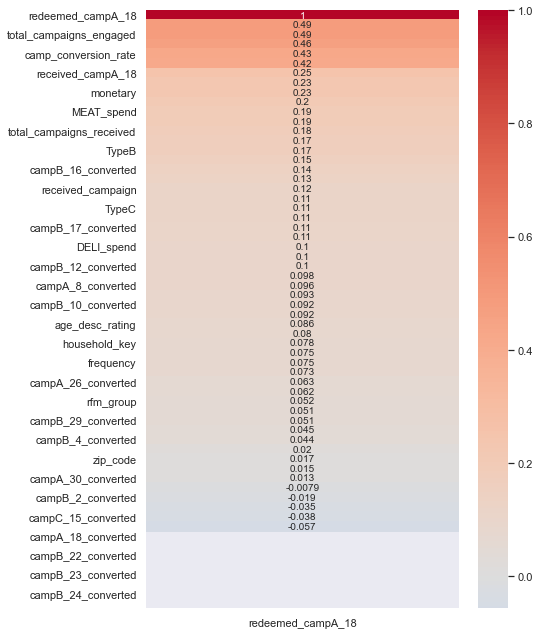

In [11]:
figure = plt.figure(figsize=(7,11))
sns.heatmap(df_household_demo.corr()[['redeemed_campA_18']].sort_values('redeemed_campA_18',ascending=False),annot=True, cmap='coolwarm', center=0);


In [268]:
df_household_demo_encoded = pd.get_dummies(data = df_household_demo, columns = cat_cols)
df_household_demo_encoded.head()

,household_key,received_campaign,redeemed_coupons,TypeA,TypeB,TypeC,total_campaigns_received,total_campaigns_engaged,total_coupons_received,total_coupons_redeemed,camp_conversion_rate,coupon_conversion_rate,recency,frequency,monetary,rfm_group,rfm_score,GROCERY_spend,DELI_spend,PRODUCE_spend,KIOSK-GAS_spend,DRUG GM_spend,NUTRITION_spend,SALAD BAR_spend,MEAT_spend,campA_26_converted,campA_30_converted,campA_8_converted,campA_13_converted,campA_18_converted,campB_28_converted,campB_29_converted,campB_1_converted,campB_2_converted,campB_4_converted,campB_5_converted,campB_7_converted,campB_9_converted,campB_10_converted,campB_12_converted,campB_11_converted,campB_16_converted,campB_17_converted,campB_19_converted,campB_22_converted,campB_21_converted,campB_23_converted,campB_25_converted,campB_24_converted,campC_27_converted,campC_3_converted,campC_6_converted,campC_14_converted,campC_15_converted,campC_20_converted,received_campA_18,redeemed_campA_18,zip_code,homeowner_desc_rating,income_desc_rating,age_desc_rating,marital_status_code_rating,segment_rating,age_desc_19-24,age_desc_25-34,age_desc_35-44,age_desc_45-54,age_desc_55-64,age_desc_65+,hh_comp_desc_1 Adult Kids,hh_comp_desc_2 Adults Kids,hh_comp_desc_2 Adults No Kids,hh_comp_desc_Single Female,hh_comp_desc_Single Male,hh_comp_desc_Unknown,homeowner_desc_Homeowner,homeowner_desc_Probable Owner,homeowner_desc_Probable Renter,homeowner_desc_Renter,homeowner_desc_Unknown,household_size_desc_1,household_size_desc_2,household_size_desc_3,household_size_desc_4,household_size_desc_5+,income_desc_100-124K,income_desc_125-149K,income_desc_15-24K,income_desc_150-174K,income_desc_175-199K,income_desc_200-249K,income_desc_25-34K,income_desc_250K+,income_desc_35-49K,income_desc_50-74K,income_desc_75-99K,income_desc_Under 15K,kid_category_desc_1,kid_category_desc_2,kid_category_desc_3+,kid_category_desc_None/Unknown,marital_status_code_A,marital_status_code_B,marital_status_code_U,segment_Champions,segment_Loyal,segment_Need attention,segment_Required activation
0,1,1,1,2.0,2.0,0.0,4.0,3.0,80.0,3.0,0.75,0.04,5,67,3362.46,333,9,2158.21,158.50,206.80,0.00,374.38,43.64,12.69,17.91,0,0,1,1,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,4,3,5,2,2,0,0,0,0,0,1,0,0,1,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,1,0,0,0,1,0,0
1,7,1,0,0.0,3.0,0.0,3.0,0.0,45.0,0.0,0.00,0.00,10,38,2320.50,223,7,1184.37,116.15,168.34,0.00,497.99,4.98,0.00,175.52,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,40243,4,4,3,2,1,0,0,0,1,0,0,0,0,1,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,1,0,0,0,0,1,0
2,8,1,1,2.0,6.0,0.0,8.0,1.0,136.0,1.0,0.12,0.01,0,90,4113.90,434,11,2208.33,45.47,183.04,188.94,688.08,11.98,50.55,261.88,0,0,1,1,0,0,1,0,0,1,1,0,0,1,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,37211,0,2,1,0,3,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,1,1,0,0,0
3,13,1,1,2.0,4.0,0.0,6.0,11.0,82.0,11.0,1.83,0.13,0,207,10138.40,444,12,3692.39,47.65,232.49,2472.86,2187.85,3.31,10.09,19.13,0,0,1,1,0,0,0,0,0,1,1,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,62946,4,5,1,0,3,0,1,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,1,1,0,0,0
4,16,1,0,1.0,1.0,0.0,2.0,0.0,32.0,0.0,0.00,0.00,4,92,1471.45,332,8,785.67,97.87,86.97,192.30,68.29,8.86,6.43,95.79,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,40241,4,4,3,1,1,0,0,0,1,0,0,0,0,0,1,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,1,0,0,0,1,0


In [14]:
from sklearn.metrics import plot_precision_recall_curve, precision_recall_curve

def plot_ROC_curve(model,X_test,y_test):

    # Generate the prediction values for each of the test observations using predict_proba() function rather than just predict
    preds = model.predict_proba(X_test)[:,1]

    # Store the false positive rate(fpr), true positive rate (tpr) in vectors for use in the graph
    fpr, tpr, _ = roc_curve(y_test, preds)

    # Store the Area Under the Curve (AUC) so we can annotate our graph with theis metric
    roc_auc = auc(fpr, tpr)

    # Plot the ROC Curve
    plt.figure()
    lw = 2
    plt.plot(fpr, tpr, color='darkorange', lw = lw, label = 'ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color = 'navy', lw = lw, linestyle = '--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.0])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic example')
    plt.legend(loc = "lower right")
    plt.show()

def display_scores(model, X_test, y_test, y_pred):
    
    # predict probabilities
    pred_probs = model.predict_proba(X_test)
    # keep probabilities for the positive outcome only
    pred_probs = pred_probs[:, 1]
    
    print('Accuracy is: ',round(accuracy_score(y_test, y_pred),2))
    print('F1 score is: ',round(f1_score(y_test, y_pred),2))
    print('Ave PR score: ',round(average_precision_score(y_test, pred_probs),2))

    cm = confusion_matrix(y_test,y_pred)
    
    sns.heatmap(cm/np.sum(cm),annot=True,fmt='.2%', cmap='Blues')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    
    print(classification_report(y_test,y_pred))
    
    plot_precision_recall_curve(model, X_test, y_test)
    
    plot_ROC_curve(model,X_test,y_test)

In [341]:
# not_included = ['campA_18_converted','total_campaigns_received','TypeA','TypeB','TypeC','household_key','received_campaign','redeemed_coupons','total_campaigns_engaged','total_coupons_received','total_coupons_redeemed','camp_conversion_rate','coupon_conversion_rate','camp_converted']

# cols = [c for c in df_household_demo_encoded.columns if c not in (not_included)]

cols1 = [
 'zip_code',
 'segment_Champions',
 'segment_Loyal',
 'segment_Need attention',
 'segment_Required activation',
 'age_desc_19-24',
 'age_desc_25-34',
 'age_desc_35-44',
 'age_desc_45-54',
 'age_desc_55-64',
 'age_desc_65+',
 'hh_comp_desc_1 Adult Kids',
 'hh_comp_desc_2 Adults Kids',
 'hh_comp_desc_2 Adults No Kids',
 'hh_comp_desc_Single Female',
 'hh_comp_desc_Single Male',
#  'hh_comp_desc_Unknown',
 'homeowner_desc_Homeowner',
# 'homeowner_desc_Probable Owner',
# 'homeowner_desc_Probable Renter',
 'homeowner_desc_Renter',
#  'homeowner_desc_Unknown',
 'household_size_desc_1',
 'household_size_desc_2',
 'household_size_desc_3',
 'household_size_desc_4',
 'household_size_desc_5+',
 'income_desc_100-124K',
 'income_desc_125-149K',
 'income_desc_15-24K',
 'income_desc_150-174K',
 'income_desc_175-199K',
 'income_desc_200-249K',
 'income_desc_25-34K',
 'income_desc_250K+',
 'income_desc_35-49K',
 'income_desc_50-74K',
 'income_desc_75-99K',
'income_desc_Under 15K',
#  'kid_category_desc_1',
#  'kid_category_desc_2',
#  'kid_category_desc_3+',
#  'kid_category_desc_None/Unknown',
 'marital_status_code_A',
 'marital_status_code_B',
# 'marital_status_code_U',
 'total_coupons_received'
]

cols2 = [
 'zip_code',
 'segment_Champions',
 'segment_Loyal',
 'segment_Need attention',
 'segment_Required activation',
 'homeowner_desc_rating',
 'income_desc_rating',
 'age_desc_rating',
 'hh_comp_desc_1 Adult Kids',
 'hh_comp_desc_2 Adults Kids',
 'hh_comp_desc_2 Adults No Kids',
 'hh_comp_desc_Single Female',
 'hh_comp_desc_Single Male',
#  'hh_comp_desc_Unknown',
 'household_size_desc_1',
 'household_size_desc_2',
 'household_size_desc_3',
 'household_size_desc_4',
 'household_size_desc_5+',
#  'kid_category_desc_1',
#  'kid_category_desc_2',
#  'kid_category_desc_3+',
#  'kid_category_desc_None/Unknown',
 'marital_status_code_rating',
 'total_coupons_received'
]

cols = cols1

X = pd.DataFrame(df_household_demo_encoded, columns = cols)

y = df_household_demo_encoded['redeemed_campA_18']


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state=42)
cols


['zip_code',
 'segment_Champions',
 'segment_Loyal',
 'segment_Need attention',
 'segment_Required activation',
 'age_desc_19-24',
 'age_desc_25-34',
 'age_desc_35-44',
 'age_desc_45-54',
 'age_desc_55-64',
 'age_desc_65+',
 'hh_comp_desc_1 Adult Kids',
 'hh_comp_desc_2 Adults Kids',
 'hh_comp_desc_2 Adults No Kids',
 'hh_comp_desc_Single Female',
 'hh_comp_desc_Single Male',
 'homeowner_desc_Homeowner',
 'homeowner_desc_Renter',
 'household_size_desc_1',
 'household_size_desc_2',
 'household_size_desc_3',
 'household_size_desc_4',
 'household_size_desc_5+',
 'income_desc_100-124K',
 'income_desc_125-149K',
 'income_desc_15-24K',
 'income_desc_150-174K',
 'income_desc_175-199K',
 'income_desc_200-249K',
 'income_desc_25-34K',
 'income_desc_250K+',
 'income_desc_35-49K',
 'income_desc_50-74K',
 'income_desc_75-99K',
 'income_desc_Under 15K',
 'marital_status_code_A',
 'marital_status_code_B',
 'total_coupons_received']

In [270]:
X_train

,zip_code,segment_rating,homeowner_desc_rating,income_desc_rating,age_desc_rating,hh_comp_desc_1 Adult Kids,hh_comp_desc_2 Adults Kids,hh_comp_desc_2 Adults No Kids,hh_comp_desc_Single Female,hh_comp_desc_Single Male,household_size_desc_1,household_size_desc_2,household_size_desc_3,household_size_desc_4,household_size_desc_5+,kid_category_desc_1,kid_category_desc_2,kid_category_desc_3+,marital_status_code_rating,total_coupons_received
616,37918,1,4,4,2,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0.0
329,40509,3,4,3,2,1,0,0,0,0,0,1,0,0,0,1,0,0,1,100.0
342,37218,3,0,1,3,0,1,0,0,0,0,0,0,1,0,0,1,0,2,47.0
394,42367,3,0,1,3,0,0,0,1,0,1,0,0,0,0,0,0,0,0,87.0
79,40505,2,0,3,2,0,0,1,0,0,0,1,0,0,0,0,0,0,2,32.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
71,37211,1,4,3,5,0,0,0,1,0,0,1,0,0,0,0,0,0,2,16.0
106,42501,1,4,5,1,0,0,0,0,1,0,1,0,0,0,0,0,0,2,0.0
270,37218,1,4,3,5,0,0,1,0,0,0,1,0,0,0,0,0,0,0,32.0
435,38583,3,4,4,3,0,1,0,0,0,0,0,0,1,0,0,1,0,0,102.0


In [342]:
#Oversampling the data

from imblearn.over_sampling import SMOTE
from collections import Counter

smote = SMOTE(random_state = 101)
X_sm, y_sm = smote.fit_resample(X, y)


# X_train_sm, X_test_sm, y_train_sm, y_test_sm = train_test_split(X_sm, y_sm,test_size=0.2,random_state=42)
Counter(y_sm)

Counter({1: 635, 0: 635})

In [343]:
ss = StandardScaler()
Xs = ss.fit_transform(X_sm)

Xs_train, Xs_test, ys_train, ys_test = train_test_split(Xs,y_sm,test_size=0.2,random_state=42)


Accuracy is:  0.87
F1 score is:  0.85
Ave PR score:  0.92
              precision    recall  f1-score   support

           0       0.86      0.90      0.88       140
           1       0.87      0.82      0.85       114

    accuracy                           0.87       254
   macro avg       0.87      0.86      0.86       254
weighted avg       0.87      0.87      0.87       254



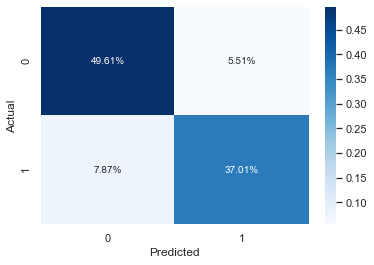

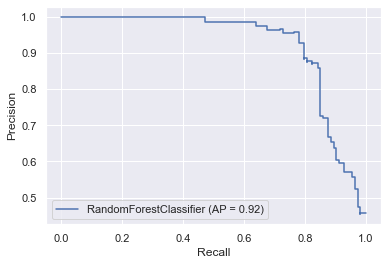

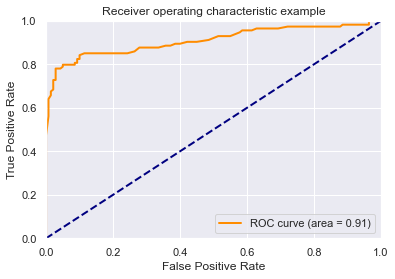

In [19]:
RF_clf = RandomForestClassifier()
    
RF_clf.fit(Xs_train,ys_train)
y_pred = RF_clf.predict(Xs_test)
display_scores(RF_clf, Xs_test, ys_test, y_pred)

Accuracy is:  0.85
F1 score is:  0.83
Ave PR score:  0.93
              precision    recall  f1-score   support

           0       0.85      0.88      0.87       140
           1       0.85      0.82      0.83       114

    accuracy                           0.85       254
   macro avg       0.85      0.85      0.85       254
weighted avg       0.85      0.85      0.85       254



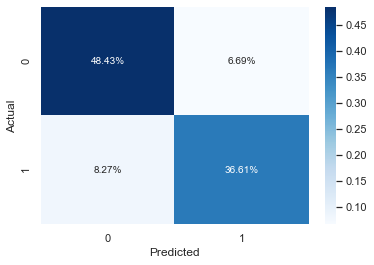

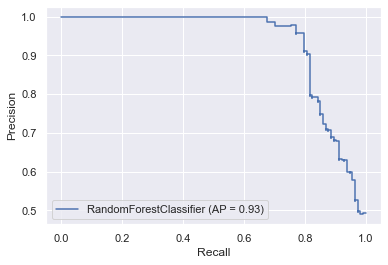

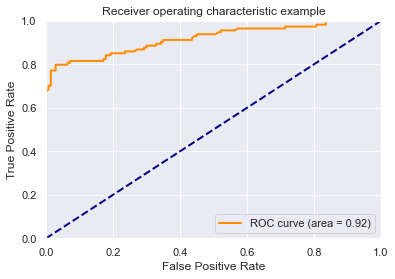

In [347]:
# cols1
RF_clf = RandomForestClassifier(max_depth=30,
                                         min_samples_leaf=1,
                                         min_samples_split=2,
                                         n_estimators=1200)

RF_clf.fit(Xs_train,ys_train)
y_pred = RF_clf.predict(Xs_test)
display_scores(RF_clf, Xs_test, ys_test, y_pred)


                     feature     score
37    total_coupons_received  0.082917
3     segment_Need attention  0.070633
0                   zip_code  0.055278
2              segment_Loyal  0.041843
31        income_desc_35-49K  0.025336
7             age_desc_35-44  0.024184
15  hh_comp_desc_Single Male  0.016891
36     marital_status_code_B  0.014971
6             age_desc_25-34  0.010365
35     marital_status_code_A  0.009981


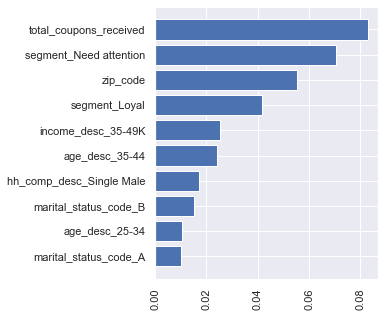

In [348]:
#cols1 
per_imp = permutation_importance(RF_clf, Xs_train,ys_train, scoring='recall')
importances = per_imp.importances_mean
    
imp_dict = dict(zip(X.columns, importances))
score_df = pd.DataFrame(imp_dict.items(), columns=['feature', 'score'])
score_df = score_df.sort_values('score',ascending=False)
print(score_df.head(10))

# plot the scores
fig = plt.figure(figsize=(4,5))
score_df = score_df.sort_values('score',ascending=False).head(10).sort_values('score',ascending=True)
plt.barh(score_df.feature, score_df.score)
plt.xticks(rotation=90)
plt.show()


Accuracy is:  0.85
F1 score is:  0.83
Ave PR score:  0.93
              precision    recall  f1-score   support

           0       0.84      0.89      0.87       140
           1       0.86      0.80      0.83       114

    accuracy                           0.85       254
   macro avg       0.85      0.85      0.85       254
weighted avg       0.85      0.85      0.85       254



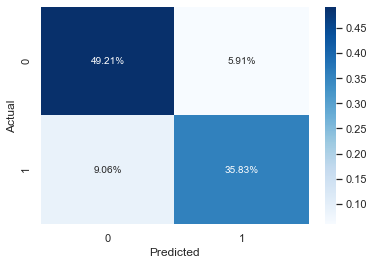

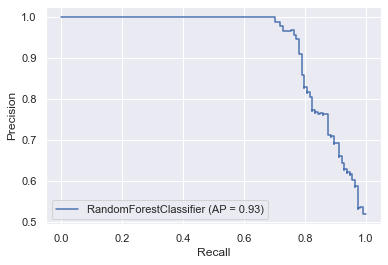

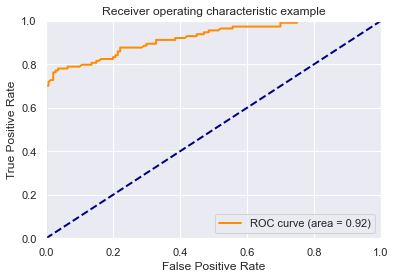

In [281]:
#cols2
RF_clf = RandomForestClassifier(max_depth=30,
                                         min_samples_leaf=1,
                                         min_samples_split=2,
                                         n_estimators=1200)

RF_clf.fit(Xs_train,ys_train)
y_pred = RF_clf.predict(Xs_test)
display_scores(RF_clf, Xs_test, ys_test, y_pred)


                       feature     score
19      total_coupons_received  0.142802
0                     zip_code  0.125528
2        homeowner_desc_rating  0.094434
4              age_desc_rating  0.072553
10       household_size_desc_1  0.065643
3           income_desc_rating  0.049520
9     hh_comp_desc_Single Male  0.047985
18  marital_status_code_rating  0.045681
1               segment_rating  0.042610
8   hh_comp_desc_Single Female  0.008445


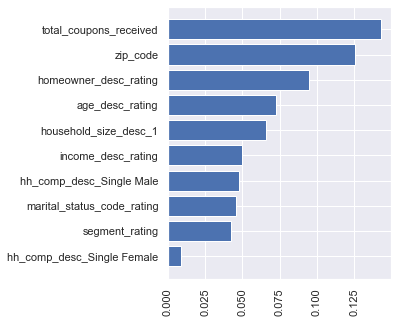

In [274]:
#cols2
per_imp = permutation_importance(RF_clf, Xs_train,ys_train, scoring='recall')
importances = per_imp.importances_mean
    
imp_dict = dict(zip(X.columns, importances))
score_df = pd.DataFrame(imp_dict.items(), columns=['feature', 'score'])
score_df = score_df.sort_values('score',ascending=False)
print(score_df.head(10))

# plot the scores
fig = plt.figure(figsize=(4,5))
score_df = score_df.sort_values('score',ascending=False).head(10).sort_values('score',ascending=True)
plt.barh(score_df.feature, score_df.score)
plt.xticks(rotation=90)
plt.show()


Accuracy is:  0.83
F1 score is:  0.81
Ave PR score:  0.93
              precision    recall  f1-score   support

           0       0.84      0.87      0.85       140
           1       0.83      0.79      0.81       114

    accuracy                           0.83       254
   macro avg       0.83      0.83      0.83       254
weighted avg       0.83      0.83      0.83       254



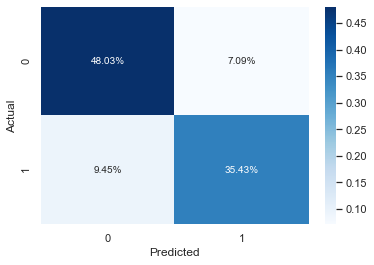

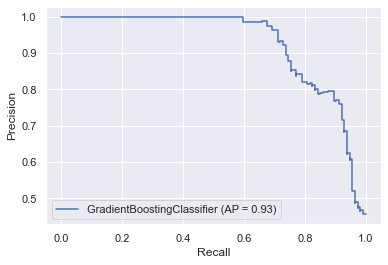

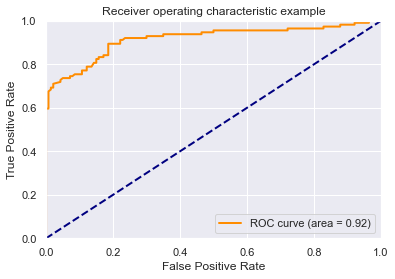

In [242]:
GB_clf = GradientBoostingClassifier(random_state=42, 
                                            learning_rate=0.01, 
                                            max_depth=7, 
                                            n_estimators=500)
                                
GB_clf.fit(Xs_train,ys_train)
y_pred = GB_clf.predict(Xs_test)
display_scores(GB_clf, Xs_test, ys_test, y_pred)

                     feature     score
0          segment_Champions  0.066027
30        income_desc_35-49K  0.048369
24        income_desc_15-24K  0.029559
31        income_desc_50-74K  0.026488
15  homeowner_desc_Homeowner  0.025720
32        income_desc_75-99K  0.025336
7             age_desc_45-54  0.024952
8             age_desc_55-64  0.022649
14  hh_comp_desc_Single Male  0.018810
5             age_desc_25-34  0.018426


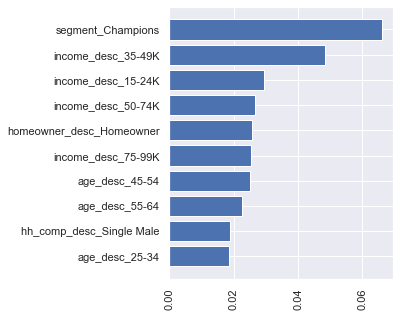

In [243]:
per_imp = permutation_importance(GB_clf, Xs_train,ys_train, scoring='recall')
importances = per_imp.importances_mean
    
imp_dict = dict(zip(X.columns, importances))
score_df = pd.DataFrame(imp_dict.items(), columns=['feature', 'score'])
score_df = score_df.sort_values('score',ascending=False)
print(score_df.head(10))

# plot the scores
fig = plt.figure(figsize=(4,5))
score_df = score_df.sort_values('score',ascending=False).head(10).sort_values('score',ascending=True)
plt.barh(score_df.feature, score_df.score)
plt.xticks(rotation=90)
plt.show()


/Users/chautran/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:892: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[13:01:17] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Accuracy is:  0.83
F1 score is:  0.81
Ave PR score:  0.93
              precision    recall  f1-score   support

           0       0.83      0.87      0.85       140
           1       0.83      0.78      0.81       114

    accuracy                           0.83       254
   macro avg       0.83      0.83      0.83       254
weighted avg       0.83      0.83      0.83       254



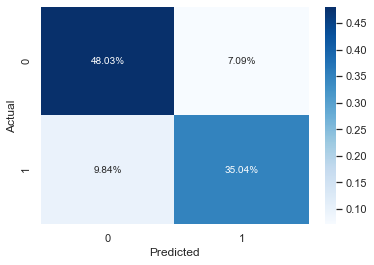

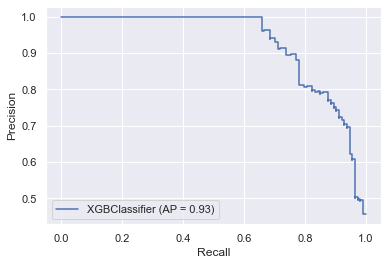

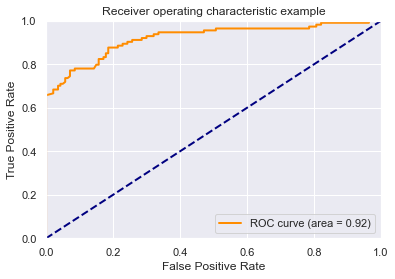

In [73]:
XGB_clf = xgb.XGBClassifier(colsample_bytree=0.6,
                                     gamma=0.5,
                                     learning_rate= 0.02,
                                     max_depth=10,
                                     min_child_weight=1,
                                     n_estimators=200,
                                     subsample=0.8)
XGB_clf.fit(Xs_train,ys_train)
y_pred = XGB_clf.predict(Xs_test)
display_scores(XGB_clf, Xs_test, ys_test, y_pred)

                   feature     score
0        segment_Champions  0.056814
30      income_desc_35-49K  0.040307
31      income_desc_50-74K  0.033013
7           age_desc_45-54  0.027255
2   segment_Need attention  0.026871
32      income_desc_75-99K  0.024568
6           age_desc_35-44  0.022649
24      income_desc_15-24K  0.021113
8           age_desc_55-64  0.016123
33   income_desc_Under 15K  0.014971


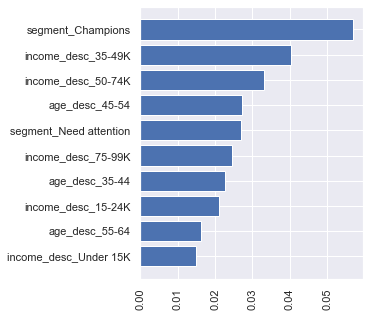

In [75]:
per_imp = permutation_importance(XGB_clf, Xs_train,ys_train, scoring='recall')
importances = per_imp.importances_mean
    
imp_dict = dict(zip(X.columns, importances))
score_df = pd.DataFrame(imp_dict.items(), columns=['feature', 'score'])
score_df = score_df.sort_values('score',ascending=False)
print(score_df.head(10))

# plot the scores
fig = plt.figure(figsize=(4,5))
score_df = score_df.sort_values('score',ascending=False).head(10).sort_values('score',ascending=True)
plt.barh(score_df.feature, score_df.score)
plt.xticks(rotation=90)
plt.show()


Accuracy is:  0.73
F1 score is:  0.73
Ave PR score:  0.88
              precision    recall  f1-score   support

           0       0.81      0.67      0.73       138
           1       0.67      0.81      0.73       116

    accuracy                           0.73       254
   macro avg       0.74      0.74      0.73       254
weighted avg       0.75      0.73      0.73       254



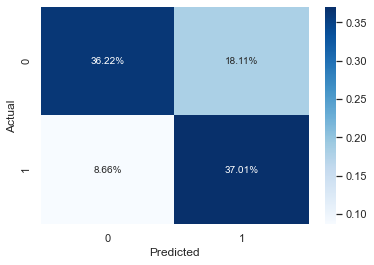

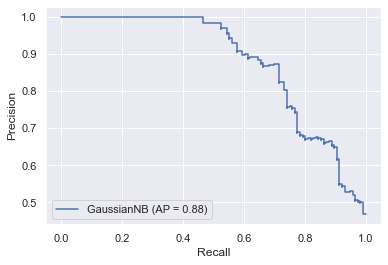

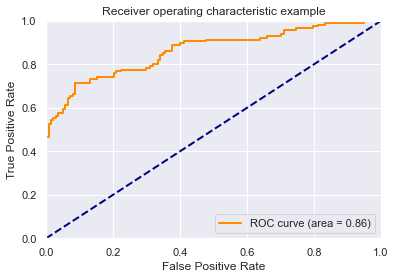

In [173]:
NB_clf = GaussianNB(var_smoothing = 1e-05)

NB_clf.fit(Xs_train,ys_train)
y_pred = NB_clf.predict(Xs_test)
display_scores(NB_clf, Xs_test, ys_test, y_pred)

Accuracy is:  0.89
F1 score is:  0.86
Ave PR score:  0.94
              precision    recall  f1-score   support

           0       0.85      0.96      0.90       140
           1       0.94      0.80      0.86       114

    accuracy                           0.89       254
   macro avg       0.90      0.88      0.88       254
weighted avg       0.89      0.89      0.88       254



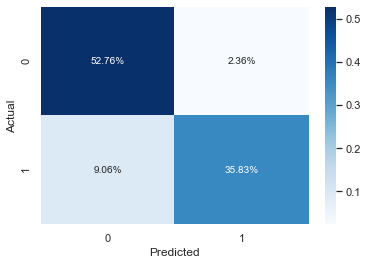

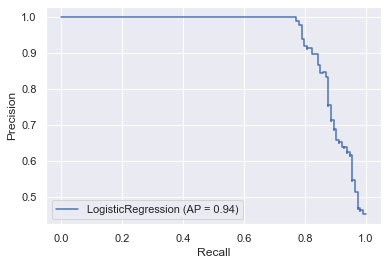

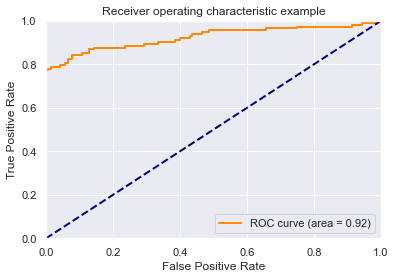

In [331]:
LG_clf = LogisticRegression(solver='liblinear',
                                       C=100,
                                       penalty='l2')

LG_clf.fit(Xs_train,ys_train)
y_pred = LG_clf.predict(Xs_test)
display_scores(LG_clf, Xs_test, ys_test, y_pred)

                       feature     score
37      total_coupons_received  0.013052
16    homeowner_desc_Homeowner  0.007294
35       marital_status_code_A  0.004607
14  hh_comp_desc_Single Female  0.003071
17       homeowner_desc_Renter  0.000768
5               age_desc_19-24  0.000768
30           income_desc_250K+ -0.000768
0                     zip_code -0.000768
36       marital_status_code_B -0.000768
28        income_desc_200-249K -0.001919


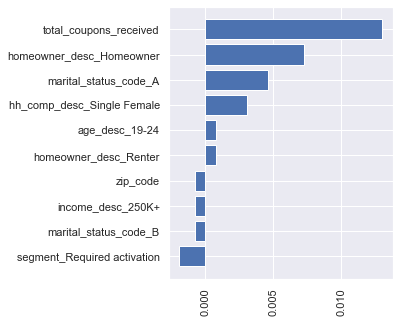

In [320]:
per_imp = permutation_importance(LG_clf, Xs_train,ys_train, scoring='recall')
importances = per_imp.importances_mean
    
imp_dict = dict(zip(X.columns, importances))
score_df = pd.DataFrame(imp_dict.items(), columns=['feature', 'score'])
score_df = score_df.sort_values('score',ascending=False)
print(score_df.head(10))

# plot the scores
fig = plt.figure(figsize=(4,5))
score_df = score_df.sort_values('score',ascending=False).head(10).sort_values('score',ascending=True)
plt.barh(score_df.feature, score_df.score)
plt.xticks(rotation=90)
plt.show()


In [332]:
print(LG_clf.coef_)

[[ 0.06916531 -3.17032235 -3.03694677 -2.36095447 -0.49774035 -1.22526342
  -1.48278262 -1.72183727 -1.8365924  -0.83511495 -0.88897012  0.13985687
   0.38524848  0.33972018  0.14514271 -0.26158089  0.24377831  0.19155354
  -2.27030089 -3.03294733 -1.94789432 -1.41485649 -1.58202462 -0.84038821
  -0.88985001 -1.44593639 -0.73204404 -0.49251927 -0.30651562 -1.26633772
  -0.6285388  -1.92285127 -2.01709317 -1.43739947 -1.20026386  0.15991358
  -0.06467679  0.40251604]]


In [97]:
def cross_val_models(X_train, X_test, y_train, y_test,imbalancedData=False,hyperTune=False):
    
    if not hyperTune:
        if imbalancedData:
            # models with hyperparams for imbalanced dataset
            models = [
                      ('LogReg', LogisticRegression(solver='liblinear')), 
                      ('RF', RandomForestClassifier(class_weight='balanced')),
                      ('GB', GradientBoostingClassifier()),
                      ('XGB', xgb.XGBClassifier(scale_pos_weight=5.2)),
                      ('KNN', KNeighborsClassifier()),
                      ('NB', GaussianNB())
                     ] 
        else:
             models = [
                      ('LogReg', LogisticRegression()), 
                      ('RF', RandomForestClassifier()),
                      ('GB', GradientBoostingClassifier()),
                      ('XGB', xgb.XGBClassifier()),
                      ('KNN', KNeighborsClassifier()),
                      ('NB', GaussianNB())
                     ] 
            
    else: 
        XGB_clf = xgb.XGBClassifier(colsample_bytree=0.6,
                                     gamma=0.5,
                                     learning_rate= 0.02,
                                     max_depth=10,
                                     min_child_weight=1,
                                     n_estimators=200,
                                     subsample=0.8)
        
        
        RF_clf = RandomForestClassifier(max_depth=30,
                                         min_samples_leaf=1,
                                         min_samples_split=2,
                                         n_estimators=1200)

        GB_clf = GradientBoostingClassifier(random_state=42, 
                                            learning_rate=0.01, 
                                            max_depth=7, 
                                            n_estimators=500)
        
        log_model = LogisticRegression(solver='liblinear',
                                       C=100,
                                       penalty='l2')

        NB_clf = GaussianNB(var_smoothing = 1e-05)
        
        models = [
                  ('LogReg', log_model), 
                  ('RF', RF_clf),
                  ('GB', GB_clf),
                  ('XGB', XGB_clf),
                  ('NB', NB_clf)
                ] 
    
    scoring = ['accuracy', 'precision', 'recall', 'f1', 'average_precision','roc_auc']
    train_score_dfs = []
    test_score_dfs = []
    test_score_dict = {}
    target_names = ['No Churn', 'Churn']
    for name, model in models:
        
        # GET TRAIN SCORES
        kfold = KFold(n_splits=5, shuffle=True, random_state=270)
        cv_results = cross_validate(model, X_train, y_train, cv=kfold, scoring=scoring)
        df1 = pd.DataFrame(cv_results)
        df1['model'] = name
        train_score_dfs.append(df1)
    
        # GET TEST SCORES
        clf = model.fit(X_train, y_train)
        y_pred = clf.predict(X_test)
        # print(name)
        # print(classification_report(y_test, y_pred, target_names=target_names))
        
        # predict probabilities
        pred_probs = model.predict_proba(X_test)
        # keep probabilities for the positive class only
        pred_probs = pred_probs[:, 1]
        
        test_score_dict = {'Accuracy': round(accuracy_score(y_test, y_pred),2),
                           'Precision': round(precision_score(y_test, y_pred),2),
                           'Recall': round(recall_score(y_test, y_pred),2),
                           'F1': round(f1_score(y_test, y_pred),2),
                           'Average PC': round(average_precision_score(y_test, pred_probs),2),
                           'ROC_AUC': round(roc_auc_score(y_test, y_pred),2)
                          }
        
        df2 = pd.DataFrame.from_dict(test_score_dict, orient='index').transpose()
        df2['Model'] = name
        test_score_dfs.append(df2)
    
    # combine all score sets into final df
    final_train_scores = pd.concat(train_score_dfs, ignore_index=True)
    final_test_scores = pd.concat(test_score_dfs, ignore_index=True)
    
    return final_train_scores, final_test_scores

In [349]:
cv_scores1, test_scores1 = cross_val_models(Xs_train, Xs_test, ys_train, ys_test,imbalancedData=False) 

/Users/chautran/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:892: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[15:16:44] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/Users/chautran/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:892: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[15:16:44] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/Users/chautran/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:892: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[15:16:44] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/Users/chautran/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:892: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[15:16:45] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/Users/chautran/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:892: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[15:16:45] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/Users/chautran/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:892: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[15:16:45] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


In [350]:
cv_report1 = cv_scores1.groupby('model').mean().sort_values(['test_accuracy','test_f1','test_average_precision'],ascending=False)
cv_report1

,fit_time,score_time,test_accuracy,test_precision,test_recall,test_f1,test_average_precision,test_roc_auc
model,,,,,,,,
LogReg,0.033351,0.010269,0.846421,0.934461,0.754709,0.834046,0.928706,0.895820
RF,0.261186,0.033689,0.843495,0.899427,0.783537,0.835914,0.927733,0.893873
XGB,0.301078,0.012770,0.815918,0.845748,0.784589,0.813271,0.922742,0.887155
GB,0.230316,0.009079,0.813962,0.855626,0.769477,0.808257,0.920432,0.885692
KNN,0.003454,0.043598,0.789375,0.794895,0.794816,0.793474,0.894938,0.873446
NB,0.001632,0.006022,0.720390,0.683445,0.858533,0.758668,0.902922,0.864730


In [351]:
cv_scores1.groupby('model').std().sort_values(['test_accuracy'],ascending=True)

,fit_time,score_time,test_accuracy,test_precision,test_recall,test_f1,test_average_precision,test_roc_auc
model,,,,,,,,
KNN,0.000608,0.008594,0.011636,0.042347,0.039233,0.014991,0.017160,0.021373
GB,0.069342,0.002958,0.030742,0.054000,0.053618,0.030224,0.020068,0.025937
LogReg,0.013638,0.004101,0.033637,0.047032,0.043276,0.032588,0.015844,0.015263
RF,0.041050,0.003030,0.033713,0.029965,0.063743,0.034030,0.017084,0.018261
XGB,0.100267,0.002158,0.035086,0.045710,0.040887,0.033094,0.020284,0.023055
NB,0.000110,0.000096,0.052678,0.073038,0.032390,0.042816,0.016347,0.025792


In [352]:
test_scores1.sort_values(['Accuracy'],ascending=False)

,Accuracy,Precision,Recall,F1,Average PC,ROC_AUC,Model
3,0.88,0.86,0.87,0.86,0.94,0.88,XGB
0,0.87,0.92,0.79,0.85,0.94,0.87,LogReg
1,0.85,0.84,0.82,0.83,0.93,0.84,RF
2,0.85,0.85,0.82,0.84,0.93,0.85,GB
4,0.83,0.80,0.83,0.82,0.90,0.83,KNN
5,0.76,0.68,0.89,0.77,0.90,0.78,NB


In [344]:
cv_scores2, test_scores2 = cross_val_models(Xs_train, Xs_test, ys_train, ys_test,imbalancedData=False,hyperTune=True)

cv_scores2.groupby('model').mean().sort_values(['test_f1','test_accuracy'],ascending=False)

/Users/chautran/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:892: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[14:57:21] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/Users/chautran/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:892: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[14:57:21] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/Users/chautran/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:892: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[14:57:22] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/Users/chautran/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:892: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[14:57:23] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/Users/chautran/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:892: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[14:57:24] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/Users/chautran/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:892: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[14:57:24] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


,fit_time,score_time,test_accuracy,test_precision,test_recall,test_f1,test_average_precision,test_roc_auc
model,,,,,,,,
RF,2.826605,0.330033,0.852342,0.902894,0.798097,0.846196,0.930658,0.897110
LogReg,0.028509,0.009646,0.848392,0.939687,0.754559,0.835915,0.928474,0.895170
XGB,0.678222,0.013007,0.834628,0.884410,0.781554,0.828365,0.929553,0.897856
GB,2.506284,0.015942,0.817898,0.844434,0.790559,0.814569,0.923810,0.886660
NB,0.002236,0.009337,0.731228,0.700487,0.836497,0.761150,0.905977,0.866080


In [345]:
cv_scores2.groupby('model').std().sort_values(['test_f1','test_accuracy'],ascending=True)

,fit_time,score_time,test_accuracy,test_precision,test_recall,test_f1,test_average_precision,test_roc_auc
model,,,,,,,,
XGB,0.049844,0.001598,0.023660,0.037837,0.045897,0.019699,0.017210,0.014588
RF,0.272780,0.030836,0.029457,0.033593,0.052396,0.030886,0.019694,0.019470
LogReg,0.002469,0.003303,0.036234,0.048313,0.046603,0.034625,0.017128,0.016832
NB,0.000078,0.000227,0.045879,0.062182,0.014567,0.037390,0.017482,0.023661
GB,0.062110,0.000234,0.041143,0.077875,0.058793,0.048923,0.023919,0.028156


In [346]:
test_scores2.sort_values(['Accuracy'],ascending=False)

,Accuracy,Precision,Recall,F1,Average PC,ROC_AUC,Model
0,0.89,0.94,0.80,0.86,0.94,0.88,LogReg
3,0.85,0.84,0.82,0.83,0.94,0.85,XGB
1,0.84,0.83,0.82,0.82,0.93,0.84,RF
2,0.83,0.81,0.83,0.82,0.93,0.83,GB
4,0.76,0.68,0.89,0.77,0.90,0.78,NB


In [33]:
# TUNING GAUSSIAN NAIVE BAYES 

NB_clf = GaussianNB()

params_NB = {'var_smoothing': np.logspace(0,-9, num=100)}
gs_NB = GridSearchCV(estimator=NB_clf, 
                 param_grid=params_NB, 
                 cv=5,   # use any cross validation technique 
                 verbose=1, 
                 scoring='accuracy') 
gs_NB.fit(Xs_train_sm,ys_train_sm)

gs_NB.best_params_

Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    1.6s finished


{'var_smoothing': 1e-05}

In [54]:
# TUNING GRADIENT BOOSTING

param_grid = {
    "n_estimators":[5,50,100,250,500,600],
    "max_depth":[1,3,5,7,9],
    "learning_rate":[0.01,0.1,1,10,100]
}

# Create a based model
gb = GradientBoostingClassifier()

# Instantiate the grid search model
grid_search = GridSearchCV(estimator = gb, param_grid = param_grid,cv = 5, n_jobs = -1, verbose = 2)
grid_search.fit(Xs_train_sm,ys_train_sm)
grid_search.best_params_

Fitting 5 folds for each of 150 candidates, totalling 750 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:    9.9s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:  1.8min
[Parallel(n_jobs=-1)]: Done 357 tasks      | elapsed:  4.4min
[Parallel(n_jobs=-1)]: Done 640 tasks      | elapsed:  8.8min
[Parallel(n_jobs=-1)]: Done 750 out of 750 | elapsed: 10.3min finished


{'learning_rate': 0.01, 'max_depth': 7, 'n_estimators': 500}

In [57]:
# TUNING LOGISTIC REGRESSION

param_grid = {'penalty' : ['l1', 'l2'],
                'C' : [100, 10, 1.0, 0.1, 0.01],
                'solver' : ['newton-cg', 'lbfgs', 'liblinear']}


# Create a based model
lr = LogisticRegression()

kfold = KFold(n_splits=5, shuffle=True, random_state=42)

# Instantiate the grid search model
grid_search = GridSearchCV(estimator = lr, param_grid = param_grid,cv = kfold, n_jobs = -1, verbose = 2)
grid_result = grid_search.fit(Xs_train_sm,ys_train_sm)
grid_search.best_params_

Fitting 5 folds for each of 30 candidates, totalling 150 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:   33.6s
[Parallel(n_jobs=-1)]: Done 150 out of 150 | elapsed:   48.7s finished


{'C': 100, 'penalty': 'l2', 'solver': 'liblinear'}

In [89]:
# TUNING RANDOMFOREST 

param_grid = {
    'max_depth': [5, 8, 15, 25, 30],
    'min_samples_leaf': [1, 2, 5, 10] ,
    'min_samples_split': [2, 5, 10, 15, 100],
    'n_estimators': [100, 300, 500, 800, 1200]
}

# Create a based model
RF = RandomForestClassifier()

# Instantiate the grid search model
grid_search = GridSearchCV(estimator = RF, param_grid = param_grid,cv = 5, n_jobs = -1, verbose = 1, scoring='recall')
grid_search.fit(Xs_train,ys_train)
grid_search.best_params_

Fitting 5 folds for each of 500 candidates, totalling 2500 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:  1.8min
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:  5.7min
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:  9.4min
[Parallel(n_jobs=-1)]: Done 792 tasks      | elapsed: 15.0min
[Parallel(n_jobs=-1)]: Done 1242 tasks      | elapsed: 24.4min
[Parallel(n_jobs=-1)]: Done 1792 tasks      | elapsed: 35.8min
[Parallel(n_jobs=-1)]: Done 2442 tasks      | elapsed: 48.8min
[Parallel(n_jobs=-1)]: Done 2500 out of 2500 | elapsed: 50.0min finished


{'max_depth': 30,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'n_estimators': 800}

In [64]:
# TUNING XBG 

xgb_cfl = xgb.XGBClassifier(n_jobs = -1)

# A parameter grid for XGBoost
param_grid = {
        'n_estimators' : [100, 200],
        'learning_rate' : [0.01, 0.02, 0.05, 0.1, 0.25],
        'min_child_weight': [1, 5, 7, 10],
        'gamma': [0.1, 0.5, 1, 1.5, 5],
        'subsample': [0.6, 0.8, 1.0],
        'colsample_bytree': [0.6, 0.8, 1.0],
        'max_depth': [3, 4, 5, 10, 12]
        }
grid_search = GridSearchCV(estimator = xgb_cfl, param_grid = param_grid,cv = 3, n_jobs = -1, verbose = 2)
grid_search.fit(Xs_train_sm,ys_train_sm)
grid_search.best_params_

Fitting 3 folds for each of 9000 candidates, totalling 27000 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:   21.9s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:   58.2s
[Parallel(n_jobs=-1)]: Done 357 tasks      | elapsed:  2.5min
[Parallel(n_jobs=-1)]: Done 640 tasks      | elapsed:  4.2min
[Parallel(n_jobs=-1)]: Done 1005 tasks      | elapsed:  6.8min
[Parallel(n_jobs=-1)]: Done 1450 tasks      | elapsed:  9.7min
[Parallel(n_jobs=-1)]: Done 1977 tasks      | elapsed: 12.8min
[Parallel(n_jobs=-1)]: Done 2584 tasks      | elapsed: 16.4min
[Parallel(n_jobs=-1)]: Done 3273 tasks      | elapsed: 20.9min
[Parallel(n_jobs=-1)]: Done 4042 tasks      | elapsed: 25.6min
[Parallel(n_jobs=-1)]: Done 4893 tasks      | elapsed: 32.7min
[Parallel(n_jobs=-1)]: Done 5824 tasks      | elapsed: 39.1min
[Parallel(n_jobs=-1)]: Done 6837 tasks      | elapsed: 47.6min
[Parallel(n_jobs=-1)]: Done 7930 tasks      | elapsed: 54.8min
[Parallel(n_jobs=-1)]: Done 9105 tasks      | 

[21:38:56] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


{'colsample_bytree': 0.6,
 'gamma': 0.5,
 'learning_rate': 0.02,
 'max_depth': 10,
 'min_child_weight': 1,
 'n_estimators': 200,
 'subsample': 0.8}

In [347]:
!pip install explainerdashboard

     |████████████████████████████████| 275 kB 1.7 MB/s eta 0:00:01
     |████████████████████████████████| 50 kB 1.8 MB/s eta 0:00:01
     |████████████████████████████████| 470 kB 1.5 MB/s eta 0:00:01
     |████████████████████████████████| 189 kB 1.4 MB/s eta 0:00:01
     |████████████████████████████████| 58 kB 1.3 MB/s eta 0:00:01
     |████████████████████████████████| 75 kB 1.0 MB/s eta 0:00:01
     |████████████████████████████████| 352 kB 1.6 MB/s eta 0:00:01
     |████████████████████████████████| 64 kB 1.6 MB/s eta 0:00:01
     |████████████████████████████████| 13.2 MB 1.6 MB/s eta 0:00:01
     |████████████████████████████████| 1.0 MB 1.5 MB/s eta 0:00:01
     |████████████████████████████████| 3.5 MB 1.4 MB/s eta 0:00:01
     |████████████████████████████████| 188 kB 1.5 MB/s eta 0:00:01
     |████████████████████████████████| 1.8 MB 1.6 MB/s eta 0:00:01
     |████████████████████████████████| 421 kB 1.4 MB/s eta 0:00:01
     |████████████████████████████████| 169 kB 1.5 

In [ ]:
from explainerdashboard import ClassifierExplainer, ExplainerDashboard

model = RandomForestClassifier(max_depth=30,
                             min_samples_leaf=1,
                             min_samples_split=2,
                             n_estimators=1200).fit(X_train, y_train)

explainer = ClassifierExplainer(model, X_test, y_test, 
                                target='redeemed_campA_18',
                                labels=['Not redeem', 'Redeemed'])

ExplainerDashboard(explainer).run()


Note: shap=='guess' so guessing for RandomForestClassifier shap='tree'...
Detected RandomForestClassifier model: Changing class type to RandomForestClassifierExplainer...
Note: model_output=='probability', so assuming that raw shap output of RandomForestClassifier is in probability space...
Generating self.shap_explainer = shap.TreeExplainer(model)
Building ExplainerDashboard..
Detected notebook environment, consider setting mode='external', mode='inline' or mode='jupyterlab' to keep the notebook interactive while the dashboard is running...
Generating layout...
Calculating shap values...
Calculating dependencies...
Calculating permutation importances (if slow, try setting n_jobs parameter)...
Calculating confusion matrices...
Calculating prediction probabilities...
Calculating predictions...
Calculating pred_percentiles...
Calculating pr auc curves...
Calculating classification_dfs...
Calculating roc auc curves...
Calculating liftcurve_dfs...
Calculating metrics...
Calculating shap in